# Preparing data for title scoring model

Let's prepare the data previously collected using parsing for the model that evaluates them. This notebook is intended for converting a dataset containing information about articles to datasets necessary for training and testing the model. The goal of the project is to increase the number of views, so we use the number of views of published articles as a criterion.

In [182]:
# data processing libraries
import numpy as np
import pandas as pd

# data processing progress bar
from tqdm.auto import tqdm
tqdm.pandas()

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# directory where all datasets are placed
DATASETS_PATH = "/home/leo/DATASETS"

%matplotlib inline

## 1. Read Dataframe with Titles and Views Numbers

Now we have a lot of data obtained as a result of web scraping, combined into one large dataset. For reading we use `read_df`, for occasional work with dataset and saving results – `write_df`.

In [716]:
def read_df(filename = 'it_articles_ru'):
    """Read total dataframe with information about all sources"""
    df = pd.read_feather(f'{DATASETS_PATH}/{filename}.feather').set_index('index')
    
    # convinient order of columns
    df = df[['title', 'short_text', 'views_num',
             'post_time', 'parse_time',
             'likes_num', 'favs_num', 'comments_num',
             'source', 'filename']]
    
    # timing cols
    for col in ('post_time', 'parse_time'):
        df[col] = pd.to_datetime(df[col])
    
    # drop dupicates, keep last of all duplicate rows
    df = df.loc[~df.index.duplicated(keep='last')]
    
    # drop non-public articles
    df = df.drop(df[df.views_num == 0.0].index)
        
    return df


def write_df(df, filename = 'it_articles_ru'):
    """Write total dataframe with information about all sources"""
    # feather format doesn't work with str indices
    df = df.reset_index()
    
    for col in ('post_time', 'parse_time'):
        df[col] = pd.to_datetime(df[col])
    
    # for space economy let's convert types
    df.views_num = df.views_num.astype('Int32')
    for col in ('likes_num', 'favs_num', 'comments_num'):
        df[col] = df[col].astype('Int16')
    
    # zstd compression is best for our str content
    df.to_feather(f'{DATASETS_PATH}/{filename}.feather',
                  compression='zstd')
    
    # convert time to simple iso format strings
    df.post_time = df.post_time.apply(lambda x: x.isoformat().replace('+03:00', ''))
    df.parse_time = df.parse_time.apply(lambda x: x.date().isoformat())
    
    print('Main datafame is saved.')
    
df = read_df()
df

,title,short_text,views_num,post_time,parse_time,likes_num,favs_num,comments_num,source,filename
index,,,,,,,,,,
https://tproger.ru/articles/kak-bystro-razvernut-hranilishhe-i-analitiku-dannyh-dlja-biznesa/,Как быстро развернуть хранилище и аналитику да...,Сегодня хочу рассказать историю проекта по зап...,7825,2021-03-01 12:32:23,2021-03-14,<NA>,<NA>,<NA>,tproger,59a7ab25-11f7-502a-b63a-bbdcb121f488
https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/,7 практических заданий с собеседования на пози...,Для начинающего разработчика очень важно не то...,6741,2021-03-01 09:05:11,2021-03-14,<NA>,<NA>,<NA>,tproger,80f10716-5243-55ca-a67d-4dfe77cd27a5
https://tproger.ru/quiz/test-chto-mozhet-jeta-nejroset/,"Тест: что реально, а что создала нейросеть?",Сегодня нейронные сети используются в сельском...,4032,2021-02-26 19:39:50,2021-03-14,<NA>,<NA>,<NA>,tproger,aaffd2c5-592f-5d7b-b972-95073d0da49a
https://tproger.ru/articles/kak-najti-dejstvitelno-horoshij-kurs-po-razrabotke-8-shagov-na-puti-k-pravilnomu-vyboru/,Как найти действительно хороший курс по разраб...,Сразу хочется пошутить и предложить разработат...,1121,2021-02-26 17:29:00,2021-03-14,<NA>,<NA>,<NA>,tproger,16f80dbb-8e7c-5a5b-9025-b2fdef30bfd0
https://tproger.ru/articles/blackbox-skanery-v-processe-ocenki-bezopasnosti-prilozhenija/,Blackbox-сканеры в процессе оценки безопасност...,Профиль задач quality engineer (QE) достаточно...,187,2021-02-26 15:16:46,2021-03-14,<NA>,<NA>,<NA>,tproger,9d58bde6-7aaf-57a4-b381-25171b9a368f
...,...,...,...,...,...,...,...,...,...,...
https://thecode.media/node-js/,Почему Node.js — это гуд,"Краткое введение в платформу, на которой JavaS...",<NA>,NaT,NaT,<NA>,<NA>,<NA>,thecode,c39ffeb0-9315-5022-bbaf-9cdb3fd717a0
https://thecode.media/go-public/,Объясни мне: как опубликовать свой сайт в инте...,"Покупаем домен, оформляем хостинг, настраиваем...",<NA>,NaT,NaT,<NA>,<NA>,<NA>,thecode,fdbd8627-8c18-56de-87c0-04c668a00b8f
https://thecode.media/chat-bot-generators/,5 проверенных сервисов для создания чат-ботов,"Статья для тех, кто еще не программирует.",<NA>,NaT,NaT,<NA>,<NA>,<NA>,thecode,6be0511b-82e0-59f8-bc97-d66713b32005


In [717]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268628 entries, https://tproger.ru/articles/kak-bystro-razvernut-hranilishhe-i-analitiku-dannyh-dlja-biznesa/ to https://thecode.media/zodiac/
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   title         268627 non-null  object        
 1   short_text    42275 non-null   object        
 2   views_num     268119 non-null  Int32         
 3   post_time     266257 non-null  datetime64[ns]
 4   parse_time    268119 non-null  datetime64[ns]
 5   likes_num     227768 non-null  Int16         
 6   favs_num      227768 non-null  Int16         
 7   comments_num  265176 non-null  Int16         
 8   source        268628 non-null  object        
 9   filename      229470 non-null  object        
dtypes: Int16(3), Int32(1), datetime64[ns](2), object(4)
memory usage: 26.0+ MB


In [687]:
write_df(df)

Main datafame is saved.


To train the `best_title` model, we need only articles containing title and number of views. For `best_title_summary` model we also need summary columns.

In [ ]:
# Соединить датасет для tproger, указать новую дату парсинга
# Добавить дату парсинга к остальным датасетам, для небольших можно адаптировать и извлечение текста
# Соединить датасеты для xakep

# Временные ячейки для работы с быстрым парсингом

In [492]:
df_proglib = pd.read_csv(f'{DATASETS_PATH}/proglib.csv')

In [493]:
df_proglib = df_proglib.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'url'])

In [497]:
df_proglib = df_proglib.rename(columns={'url-href': 'url'}).set_index('url')

In [505]:
for col in ('likes_num', 'views_num', 'favs_num', 'comments_num'):
    df_proglib[col] = df_proglib[col].fillna(0) 

In [512]:
df_proglib['parse_time'] = pd.to_datetime('today').date()

In [514]:
df_proglib['source'] = 'proglib'

In [519]:
df = read_df()

In [508]:
df_proglib.comments_num = df_proglib.comments_num.apply(int)

In [485]:
pd.read_csv(f'{DATASETS_PATH}/proglib-full2.csv')

,web-scraper-order,web-scraper-start-url,title,short_text,likes_num,views_num,favs_num,comments_num,url,url-href,full_text
0,1618750497-8864,https://proglib.io/,Legacy: что нужно знать о работе с чужим кодом,"Доходчивый гайд по работе с legacy кодом, кото...",1,21508,0,Обсудить,Legacy: что нужно знать о работе с чужим кодом...,https://proglib.io/p/legacy-code,Библиотека программиста\n ...
1,1618748977-8319,https://proglib.io/,Cистема контроля версий Git: расширенная шпарг...,Inventore praesentium eos velit tenetur. Repel...,2,31062,4,Обсудить,Cистема контроля версий Git: расширенная шпарг...,https://proglib.io/p/git-tips,Библиотека программиста\n ...
2,1618748818-8261,https://proglib.io/,Хочу делать игры. Как этому научиться?,"Рассказываем, как начать разрабатывать игры и ...",1,47525,3,Обсудить,Хочу делать игры. Как этому научиться?\n ...,https://proglib.io/p/how-to-start-develop-games,Библиотека программиста\n ...
3,1618749388-8469,https://proglib.io/,Тренируй свои мозги или ТОП-15 логических задач,"Развиваться необходимо, особенно в сфере IT, ...",0,33655,1,Обсудить,Тренируй свои мозги или ТОП-15 логических зада...,https://proglib.io/p/train-your-brain,Библиотека программиста\n ...
4,1618749429-8484,https://proglib.io/,Оптимизация сайта – это просто: объясняем на п...,"Оптимизация сайта – это просто. Рассказываем, ...",0,10172,2,Обсудить,Оптимизация сайта – это просто: объясняем на п...,https://proglib.io/p/website-optimization,Библиотека программиста\n ...
...,...,...,...,...,...,...,...,...,...,...,...
1311,1618750086-8719,https://proglib.io/,"Псс! Вы знали, что ReasonReact – лучший способ...",React – замечательный инструмент для создания ...,0,8299,2,Обсудить,"Псс! Вы знали, что ReasonReact – лучший способ...",https://proglib.io/p/reasonreact,Библиотека программиста\n ...
1312,1618749492-8506,https://proglib.io/,"5 особенностей языка Java, о которых вы должны...",О некоторых особенностях языка Java порой не з...,0,20022,2,Обсудить,"5 особенностей языка Java, о которых вы должны...",https://proglib.io/p/java-hidden-secrets,Библиотека программиста\n ...
1313,1618750129-8735,https://proglib.io/,Когда скончалась фантазия: подборка идей для с...,"Реализовываете скучные концепции, потому что т...",0,8953,0,Обсудить,Когда скончалась фантазия: подборка идей для с...,https://proglib.io/p/more-project-ideas,Библиотека программиста\n ...
1314,1618750839-8982,https://proglib.io/,"8 плохих практик JavaScript, которые 100% прив...","Разобрали восемь практик JavaScript, в рамках ...",2,13256,10,3,"8 плохих практик JavaScript, которые 100% прив...",https://proglib.io/p/8-javascript-practices,Библиотека программиста\n ...


In [454]:
import datetime
import dask.dataframe as dd
import re

df = dd.read_csv(f'{DATASETS_PATH}/xakep*.csv', dtype={'views_num': 'object', 'comments_num': 'object'}).compute()
df = df.set_index('title-href')
df = df.drop(columns='web-scraper-order')
#df['pag_start'] = df['web-scraper-start-url'].apply(lambda x: int(x.split('/')[-2]))
df = df.drop(columns='web-scraper-start-url')

# преобразуем количество просмотров
df.views_num = df.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))

# удаляем закрытые и недоступные статьи
df = df.drop(df[df.views_num == 0.0].index)

# удаляем дубликаты
df = df.loc[~df.index.duplicated(keep='last')]

def find_digit(s):
    digit_string = re.findall(r'\d+', s)
    if digit_string:
        return int(digit_string[0])
    else:
        return 0

df.comments_num = df.comments_num.apply(find_digit)

df['parse_time'] = datetime.datetime.now().date()
df['comments_num'] = df['comments_num'].astype('int8')
df['post_date'] = pd.to_datetime(df['post_date'], dayfirst=True, errors='coerce')
df_tmp = df.rename({'title-href':'url', 'post_date':'post_time'}, axis=1)
df_tmp = df_tmp.reset_index().rename(columns={'title-href':'url'}).set_index('url')
#df.to_csv(f'{DATASETS_PATH}/xakep.csv')
#df.sort_values(by='comments_num', ascending=False)

Когда есть полные дубликаты заголовков, оставлять тот, что имеет больше просмотров.

In [458]:
pd.concat([df, df_tmp])

In [481]:
write_df(df)

Main datafame is saved.


## 2. ML Correction of Underestimated Number of Views
The number of views on sites sometimes significantly lags behind the expected or is not always calculated correctly. For example, for new articles, or articles that changed the publicity status. This is especially noticeable when the number of views is less than the number of likes and bookmarks. To correct such values, we build a simple SGD regression model on data we can trust. Next, we extrapolate the result to "suspicious" data.

- В обучении нужно учитывать ресурс - для разных источников разная склонность к 
- Вместо разницы с текущем временем корректнее использовать дату парсинга

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

df['post_time'] = pd.to_datetime(df['post_time'], utc=True)
df['mln_secs_to_now'] = (pd.Timestamp.now(tz='UTC') - df['post_time']).apply(lambda x: x.total_seconds())*1e-6
df_tmp = df[['likes_num', 'favs_num', 'comments_num', 'views_num']].dropna()
df_tmp['suspicious'] = [False]*df_tmp.shape[0]
for col in ('likes', 'favs', 'comments'):
    df_tmp['suspicious'] += df_tmp[f'{col}_num'] > 0.1*df_tmp['views_num']

df_tmp_susp = df_tmp[df_tmp['suspicious'] == True]
df_tmp = df_tmp[df_tmp['suspicious'] == False]
df_tmp = df_tmp.drop(columns=['suspicious'])
df_tmp_susp = df_tmp_susp.drop(columns=['suspicious'])

y = df_tmp['views_num']
X = df_tmp.drop(columns=['views_num'])
reg = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_jobs=20))
reg.fit(X, y)
df_tmp_susp['views_num'] = reg.predict(df_tmp_susp.drop(columns=['views_num']))
df_tmp_susp['views_num'] = df_tmp_susp['views_num'].apply(round)
df_tmp = pd.concat([df_tmp, df_tmp_susp])
df.update(df_tmp)

## 3. Target Variable Conversion: Views to Rating

Let's create datasets with the minimum required set of columns, corresponding for each model:

model | title | summary | views_num
--- | --- | --- | ---
`best_title` | `True` | `False` | `True`
`best_title_summary` | `True` | `True` | `True`

In the dataset for the title model and the summary model, the differences will be in more than just one column. Posts with the same name can have different descriptions. In such cases, in the title rating dataset, we take the number of views for the least viewed post, assuming that a short description increases engagement but does not degrade it.

Now we will sort the articles by the number of views and set each position in the top 20% to 1, and for the rest – 0. So the closer the classification score to 1, the more likely the article will receive more views.

In [ ]:
df.title[df.title.duplicated()]

In [109]:
Xy = df[['title', 'views_num']]
Xy['title'] = Xy['title'].apply(str)
#max_title_length = Xy.title.apply(len).max()
Xy.sort_values(by='views_num', inplace=True)

bound = round(Xy.shape[0]*0.2)
Xy['score'] = 0
Xy.score.iloc[-bound:] = 1
Xy['score'] = Xy['score'].astype('int8')
Xy.drop(columns='views_num', inplace=True)

In [110]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229192 entries, https://habr.com/ru/post/81826 to https://habr.com/ru/post/491974
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   229192 non-null  object
 1   score   229192 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 3.7+ MB


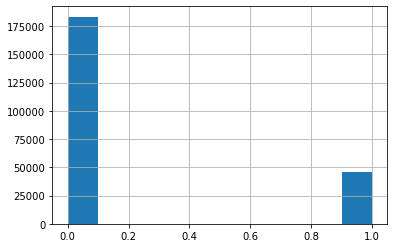

In [111]:
Xy.score.hist()

In [112]:
Xy.to_pickle('Xy.pickle', compression='gzip', protocol=4)

# XXX Archive & Drafts XXX

In [ ]:
# df_digitalocean = pd.read_csv(f'{DATASETS_PATH}/digitalocean.csv')
# df_digitalocean = df_digitalocean.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
# df_digitalocean = df_digitalocean.set_index('title-href')
# df_digitalocean['post_time'] = pd.to_datetime(df_digitalocean['post_time'])
# df_digitalocean['parse_time'] = pd.to_datetime('today').date()
# df_digitalocean['views_num'] = df_digitalocean['views_num'].apply(lambda x: int(float(x.replace('k', 'e+3'))))
# df_digitalocean['source'] = 'digitalocean'

# df_digitalocean = df_digitalocean.reset_index()
# df_digitalocean = df_digitalocean.set_index('title-href')
# df_digitalocean.apply(lambda x: save_new_data(x.filename, x.source, x.full_text), axis=1)

# import uuid

# def save_new_data(filename, source, full_text):
#     '''Сохраняет новые данные в датафрейм, а текст -- в отдельный файл'''
#     filepath = f"{DATASETS_PATH}/{source}/{filename}"
#     if not os.path.exists(filepath):
#         with open(filepath, 'w') as f:
#             full_text = re.sub('\n+', '\n\n', full_text).strip()
#             f.write(full_text)
#     else:
#         pass

# парсинг сайтов с помощью расширения web scrapy
# def filter_df(df):
#     # drop all non-digit symbols in views of num
#     df.views_num = df.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))



# import datetime

# df_tmp = pd.read_csv(f'{DATASETS_PATH}/xakep.csv')
# df_tmp = df_tmp.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
# df_tmp = df_tmp.set_index('title-href')
# #df_tmp = df_tmp.fillna(0)

# def find_digit(s):
#     digit_string = re.findall(r'\d+', s)
#     if digit_string:
#         return int(digit_string[0])
#     else:
#         return 0

# df_tmp.comments_num = df_tmp.comments_num.apply(find_digit)
# df_tmp['parse_time'] = datetime.datetime.now()
# df_tmp['comments_num'] = df_tmp['comments_num'].replace('Обсудить', '0')
# df_tmp['comments_num'] = df_tmp['comments_num'].astype('int8')
# df_tmp['likes_num'] = df_tmp['likes_num'].astype('int8')
# df_tmp['favs_num'] = df_tmp['favs_num'].astype('int8')
# df_tmp.set_index('url-href').to_csv(f'{DATASETS_PATH}/thecode.csv')

In [ ]:
# генерация дополнительных признаков
# Xy.loc[:, ['title']] = Xy.title.apply(str)

# Xy.loc[:, ['doc']] = Xy.title.progress_apply(nlp)

# длина заголовка в символах
# Xy.loc[:, ['len']] = Xy.title.apply(len)

# количество токенов
# Xy.loc[:, ['tokens_num']] = Xy.tokens.apply(lambda x: len(x))

# Токенизация большого числа заголовков — затратная по времени операция.
# Поэтому предварительно токенизированные заголовки хранятся в виде
# сжатого датафрайма
#tokenized_titles = pd.read_pickle(TOKENIZED_TITLES_PATH, compression='gzip')

# for i in [3, 8, 9]:
#     spacy.displacy.render(tokenized_titles.iloc[i], style='ent', jupyter=True)

# tokenized_titles.to_pickle(path=TOKENIZED_TITLES_PATH, compression='gzip')